In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.filters.hp_filter import hpfilter
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime as dt
import seaborn as sns
import os

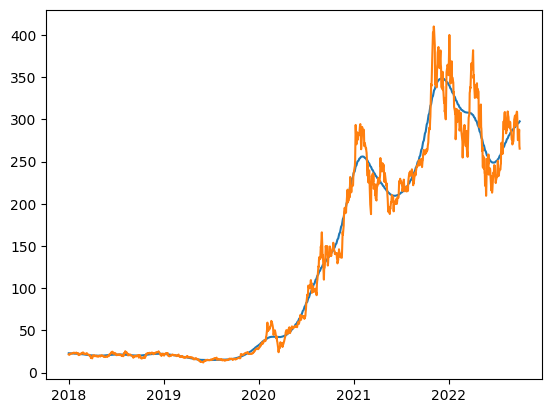

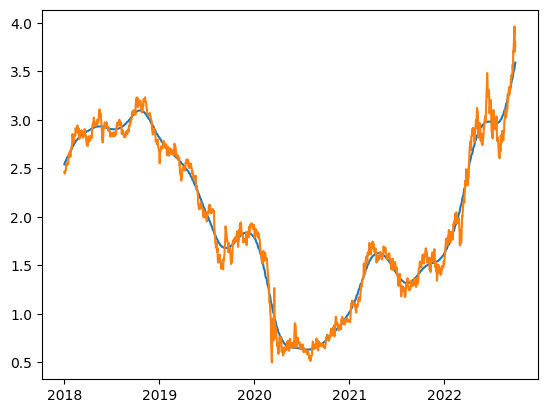

timeLag                  1           2           3           4           5    \
Date                                                                           
2018-12-31 Close   22.257999   21.075333   21.739332   19.692667   21.318001   
2019-01-02 Close   22.186666   22.257999   21.075333   21.739332   19.692667   
2019-01-03 Close   20.674667   22.186666   22.257999   21.075333   21.739332   
2019-01-04 Close   20.024000   20.674667   22.186666   22.257999   21.075333   
2019-01-07 Close   21.179333   20.024000   20.674667   22.186666   22.257999   
...                      ...         ...         ...         ...         ...   
2022-09-26 Close  275.329987  288.589996  300.799988  308.730011  309.070007   
2022-09-27 Close  276.010010  275.329987  288.589996  300.799988  308.730011   
2022-09-28 Close  282.940002  276.010010  275.329987  288.589996  300.799988   
2022-09-29 Close  287.809998  282.940002  276.010010  275.329987  288.589996   
2022-09-30 Close  268.209991  287.809998

In [5]:

def produceHP(ticker):
    ticker = "\\Data\\{}".format(ticker) + ".csv"
    dir = os.getcwd() + ticker
    data = pd.read_csv(dir)
    data = data.set_index('Date')
    x = data.index
    x = [dt.datetime.strptime(d, '%Y-%m-%d') for d in x]
    price = data['Close']
    cycle, trend = sm.tsa.filters.hpfilter(price, 100000)
    y = trend
    plt.plot(x, y)
    y = price
    plt.plot(x, y)
    plt.show()
    return data
data = produceHP("TSLA")
produceHP("^TNX")


data_reshape = pd.concat([data['Close'].T.shift(i+1).to_frame().stack(dropna=False) for i in range(250) ], 1).dropna()
data_reshape.columns = pd.Index(range(1,251), name='timeLag')
print(data_reshape)

In [8]:
def getBinomArray(num):
    arr = np.array(num + 1)
        

def approximate(data):
    cycle, trend = sm.tsa.filters.hpfilter(data, 100000)
    fx = trend
    for i in range(10):
        coeff = getBinomArray(i)

In [7]:
for i in range(len(data_reshape)):
    row = data_reshape.iloc[i]
    approximate(row)

(250,)
